# Tutorial on Multi-Layer Perceptron

In this tutorial, we will work on creating a multi-layer perceptron to classify hand-written digits from the MNIST dataset using Tensorflow and Keras. (Keras is part of Tensorflow as of TF 2.0)

We will explore the effect of the size of the training and testing sets as well as overfitting & underfitting.

In [ ]:
# import required packages
import numpy as np
import matplotlib.pyplot as plt
import tensorflow.keras as keras
# make it easier to understand by importing the required libraries within keras
from tensorflow.keras.layers import Dense, Flatten
from statistics import mean
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

## Step 1: Load and explore the dataset
First step is to load the fashion MNIST dataset. Keras has functions to directly download some famous __[datasets](https://www.tensorflow.org/api_docs/python/tf/keras/datasets)__. The first time you run this command, it will install the dataset. 

The dataset contains 70,000 samples. Each sample is a single channel (i.e. grayscale) 28x28 (pixels) image.

We have 10 classes:
T-shirt/top
Trouser
Pullover
Dress
Coat
Sandal
Shirt
Sneaker
Bag
Ankle boot


In [ ]:
(x_train, y_train), (x_test, y_test) = keras.datasets.fashion_mnist.load_data()

# explore the dataset
print('Training set shape: {}'.format(x_train.shape))
print('Training labels shape: {}'.format(y_train.shape))
print('Test set shape: {}'.format(x_test.shape))
print('Test labels shape: {}'.format(y_test.shape))

4431872/4422102 [==============================] - 0s 0us/step
Training set shape: (60000, 28, 28)
Training labels shape: (60000,)
Test set shape: (10000, 28, 28)
Test labels shape: (10000,)


As we can see, the training set has 60k images while the test set has 10k.

Let us have a closer look at the dataset before we start working with it. It is always a good practice to check the size, the range of values for the input and output, and visualize a few samples.

It is also a good idea to check the format of the labels. They may be given as integers of on-hot encoded vectors.

Sample labels are: [9 0 0 3 0 2 7 2 5 5 0 9 5 5 7 9 1 0 6 4]
The classes are: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
The values in the input data range from 0 to 255


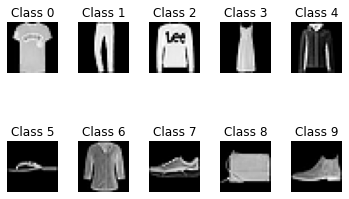

In [ ]:
labels = set(y_train)

print('Sample labels are: {}'.format(y_train[:20]))
print('The classes are: {}'.format(labels))
print('The values in the input data range from {} to {}'.format(x_train.min(),x_train.max()))

# Visualize a sample from each class
i = 0
for label in labels:
    imgs = x_test[y_test==label]
    img = imgs[0]
    
    # plot
    plt.subplot(2,5,i+1)
    plt.imshow(img, cmap='gray')
    plt.title('Class %.f' %label)
    plt.axis('off')
    plt.subplots_adjust(wspace = 0.4)
    i+=1


We have 10 classes as expected (0-9). The values of the input range from 0-255, and this seems correct since the images are all in grayscale.

If you are using a pre-trained model, it is important to know what normalization was used on the input in training and use the same on your input data. Likewise, your training and testing data should be normalized in the same way.

We usually normalize images to have pixel values in the range of 0-1 or 0 mean and unit variance.

In this example, we will normalize using min-max normalization which will set all our values to have a minimum of 0 and a maximum of one.

$x_{i}' = \frac{x_{i}-min(x)}{max(x)-min(x)}$

Where x is the feature (column). We already know that the minimum value is 0 and the maximum is 255 for all features, so we'll directly apply that in our equation. 

An alternative would be to use __[MinMax scaler from sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.minmax_scale.html#sklearn.preprocessing.minmax_scale)__.

In [ ]:
x_train = x_train.astype(float)/255
x_test = x_test.astype(float)/255
print('The values in the input data range from {} to {}'.format(x_train.min(),x_train.max()))

The values in the input data range from 0.0 to 1.0


We will be using softmax as the activation function in the last layer, which outputs our labels one-hot encoded. Generally, we should convert our input labels to the same format. 

Although tf and keras do that automatically and this is not required in this example, we will go ahead with it to conform to the general case. 

In [ ]:
# make sure that the labels are still integers (this cell has not been run before)
if len(y_train.shape)==1:
    y_train = keras.utils.to_categorical(y_train, num_classes=10)
    y_test = keras.utils.to_categorical(y_test, num_classes=10)
print(y_train.shape, y_test.shape)
print(y_train[0:3])
print('Old labels: {}'.format(np.argmax(y_train[:3], axis=1)))

(60000, 10) (10000, 10)
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
Old labels: [9 0 0]


## Step 2: Defining the MLP Model
Now that we have loaded, explored, and preprocessed the dataset, we are ready to create the MLP that we will train to classify the dataset.

We will use Keras Sequential API within tensorflow. We will build an MLP with 2 hidden layers (and an input and output layer). All layers in an MLP are fully connected, sometimes also called 'dense' layers.

We will first 'Flatten' the input to be one column of (28x28) 784 values. Then we expect the first Dense layer to allow for an input of size 784. 

We also need to define the number of neurons in each layer. For now, we will go with 64 neurons in each layer. We will also use a Sigmoid activation function for both layers.

For the output layer, we need to define the number of units and the type of activation function. Since we will be using a softmax activation function, then we need 10 units in the output layer.

In the sequential API from Keras, we define the layers as stacked after one another. You can define them all in one line, or in separate calls to the function 'add'. Just remember that the layers are put in the order you define them.

In [ ]:
# define the model type (still empty)
mlp = keras.models.Sequential()

# add a layer that just flattens the input (no weights here)
mlp.add(Flatten(input_shape=(28, 28)))

# add the first hidden layer with 64 neurons, an activation function of sigmoid,
# and an input size of 784
mlp.add(Dense(64, activation='sigmoid', input_shape=(784,)))

# add the second hidden layer with 64 neurons and sigmoid activation function
mlp.add(Dense(64, activation='sigmoid'))

# add the output layer with 10 units and Softmax activation function
mlp.add(Dense(10, activation='softmax'))

## You can also create the same exact network at once:
# model = keras.models.Sequential([
#   Flatten(input_shape=(28, 28)),
#   Dense(64, activation='sigmoid', input_shape=(784,)),
#   Dense(64, activation='sigmoid'),
#   Dense(10, activation='softmax')
# ])

print(mlp.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 64)                50240     
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 10)                650       
                                                                 
Total params: 55,050
Trainable params: 55,050
Non-trainable params: 0
_________________________________________________________________
None


We now have the network all set. 

We need to define the optimization process:
* What is the loss function that we will try to minimize
* What optimizer do we want to use
* Metrics we would like to monitor during training (these do not affect the optimization)

The loss function depends on the problem we are trying to solve. For multi-class classification, we will use the cross-entropy loss for categorical data: *categorical_crossentropy* in keras.

As for the optimizer, we will be using Adam  (a variant of gradient descent) with the default parameters.

We will also monitor the accuracy of prediction on the training set using the accuracy metric.

To add these parameters, we will compile the model and pass them to the model.

In [ ]:
mlp.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

## Step 3: Training the Model
We can now begin our training.

Suppose our training set is made of 200 samples only. Let's begin training with that for 100 epochs and see how our network behaves.

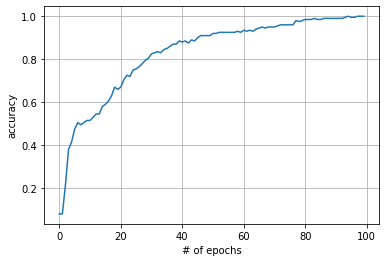

In [ ]:
h = mlp.fit(x_train[:200], y_train[:200], epochs=100, batch_size=40, verbose=0)

# plot the training accuracy
plt.plot(h.history['accuracy'])
plt.xlabel("# of epochs")
plt.ylabel("accuracy")
plt.grid()

In [ ]:
print(x_train.shape)

(60000, 28, 28)


Very quickly, we reach an accuracy of 100%. You may be tempted to think that your model is good and it can perform well on future data. However, this accuracy is on the training data, and it may not be representative of test accuracy. This can happen for different reasons (mismatch between training and test distributions, limited data, overfitting, etc.)

When training a model, what you need to be monitoring is the loss/accuracy on a held-out set, called the **validation set**. So, let’s evaluate our model on the test set to see how it does there.

In [ ]:
print('Test accuracy: %.2f %%'%(100*mlp.evaluate(x_test,y_test, verbose=0)[1]))

Test accuracy: 73.48 %


Notice how the model does poorly on the test set, and compare that to how well it does on the training set. The reason in this case is that we did not use enough training data, and the model did not generalize enough.

Let's use the whole training set and take 25% of it as a validation set to monitor the performance.

In [ ]:
h = mlp.fit(x_train, y_train, epochs=10, batch_size=32, validation_split=0.25, verbose=0)

train acc: 90.06 % 
val acc: 87.60 %


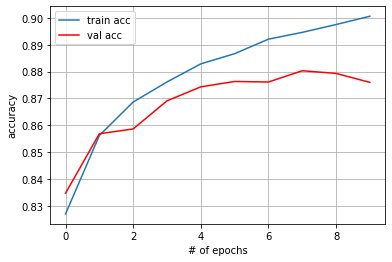

In [ ]:
plt.plot(h.history['accuracy'])
plt.plot(h.history['val_accuracy'], 'r')
plt.legend(['train acc', 'val acc'])
plt.xlabel("# of epochs")
plt.ylabel("accuracy")
plt.grid()

print('train acc: %.2f %% \nval acc: %.2f %%'%(h.history['accuracy'][-1]*100,h.history['val_accuracy'][-1]*100))

Evaluate the test set again to see if this changes anything

In [ ]:
print('Test accuracy: %.2f %%'%(100*mlp.evaluate(x_test,y_test, verbose=0)[1]))

Test accuracy: 86.60 %


So we can see that the validation accuracy is a better estimate of the test accuracy.

In [ ]:
#add another hidden layer to test the performance
h_total_train=np.empty((0,10))
h_total_val=np.empty((0,10))
total_acc=[]
number_of_runs=10
for i in range(number_of_runs):
  mlp =keras.models.Sequential([
  Flatten(input_shape=(28, 28)),
  Dense(64, activation='sigmoid', input_shape=(784,)),
  Dense(64, activation='sigmoid'),
  Dense(10, activation='softmax')])
  mlp.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  h = mlp.fit(x_train, y_train, epochs=10, batch_size=32, validation_split=0.25, verbose=0)
  h_total_train=np.append(h_total_train,np.array([h.history['accuracy']]),axis=0)
  h_total_val=np.append(h_total_val,np.array([h.history['val_accuracy']]),axis=0)
  total_acc.append(mlp.evaluate(x_test,y_test, verbose=0)[1])

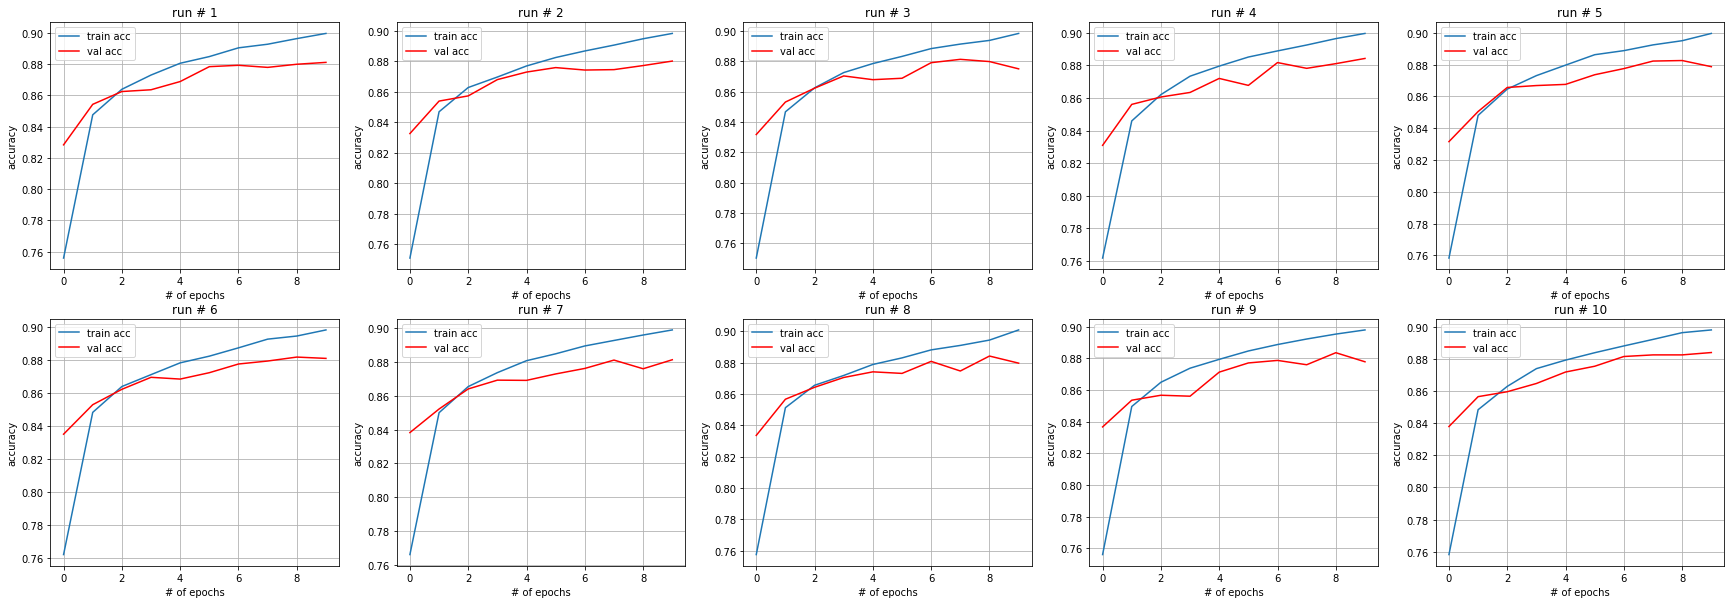

In [ ]:
for i in range(number_of_runs):
  f=plt.subplot(2,5,i+1)
  f.figure.set_size_inches(30,10)
  plt.plot(h_total_train[i])
  plt.plot(h_total_val[i],'r')
  plt.legend(['train acc', 'val acc']) 
  plt.title("run # %d"%(i+1))
  plt.xlabel("# of epochs")
  plt.ylabel("accuracy")
  plt.grid()


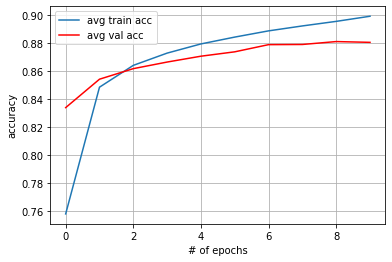

In [ ]:
h_avg_train=np.average(h_total_train,axis=0)
h_avg_val=np.average(h_total_val,axis=0)
plt.plot(h_avg_train)
plt.plot(h_avg_val, 'r')
plt.legend(['avg train acc', 'avg val acc'])
plt.xlabel("# of epochs")
plt.ylabel("accuracy")
plt.grid()


In [ ]:
print('Test accuracy: %.2f %%'%(100*mean(total_acc)))

Test accuracy: 87.08 %


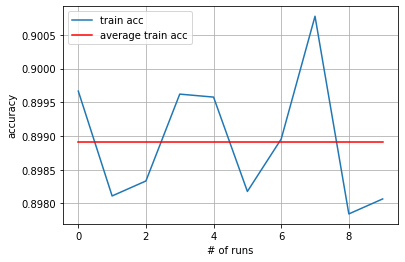

In [ ]:
ten_runs_train=[]
ten_runs_val=[]
for i in range(number_of_runs):
  ten_runs_train.append(h_total_train[i][-1])
  ten_runs_val.append(h_total_val[i][-1])

plt.plot(ten_runs_train)
plt.plot(range(0,10),[h_avg_train[-1]]*10,'r')
plt.legend(['train acc', 'average train acc']) 
plt.xlabel("# of runs")
plt.ylabel("accuracy")
plt.grid()

## Overfitting
In some cases, a model could be overfit the training data. You can idenitfy this situation if you notice your training accuracy increasing while the validation accuracy is decreasing. 
* Adding more training data is one way to counter this issue, but that is not always feasible.
* Another approach is to simplify your model: if your model is a very high capacity (many layers/units) while your data is limited, you are probably going to overfit. 

To see this in action, let’s look at this toy regression example.

Suppose the input is 2-dimensional ($x_{1}$, $x_{2}$) and that $y = 3x_{1} + 2x_{2}$ + 2n, where n is some random
noise. 

Let’s generate 100 samples from this model.

In [ ]:
x = 6*np.random.rand(100,2) -3
y = 3*x[:,0] + 2*x[:,1] + 2*np.random.rand(100,)

Now we'll create an MLP for this regression problem, this will follow the same steps bit with a few differences in the loss and kind of activation function.

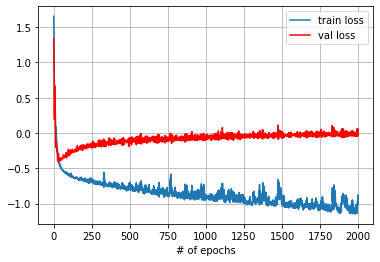

In [ ]:
mlp = keras.models.Sequential([
    Dense(1024, activation='relu', input_shape=(2,)),
    Dense(512, activation='relu'),
    Dense(1, activation='linear')
          ])
mlp.compile(loss='mean_squared_error', optimizer='adam')

h = mlp.fit(x, y, epochs=2000, batch_size=50, validation_split=0.3, verbose=0)

plt.plot(np.log10(h.history['loss']))
plt.plot(np.log10(h.history['val_loss']), 'r')
plt.legend(['train loss', 'val loss'])
plt.xlabel("# of epochs")
plt.grid()

Note how the validation goes down at first, and then starts to go back up. This is an indication of overfitting. One way to counter this (aside from adding more data), is to use early stopping: stop training when the validation loss begins to increase.

Another approach, as we mentioned earlier, is to simplify our model, say by reducing the number of units from 1024 to 64 and removing the second hidden layer.

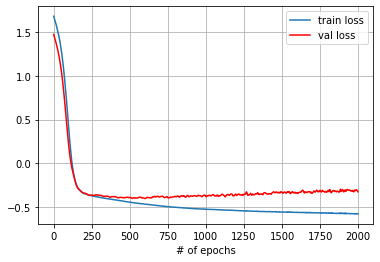

In [ ]:
mlp2 = keras.models.Sequential([
    Dense(64, activation='relu', input_shape=(2,)),
    Dense(1, activation='linear')
          ])
mlp2.compile(loss='mean_squared_error', optimizer='adam')


h = mlp2.fit(x, y, epochs=2000, batch_size=50, validation_split=0.3, verbose=0)
plt.plot(np.log10(h.history['loss']))
plt.plot(np.log10(h.history['val_loss']), 'r')
plt.legend(['train loss', 'val loss'])
plt.xlabel("# of epochs")
plt.grid()

In [ ]:
from tqdm.auto import tqdm

In [ ]:
acc_list = list()
for n_layers in tqdm(range(1, 10)):
  tmp_acc_list = list()
  for _ in range(10):
    mlp = keras.models.Sequential()
    mlp.add(Flatten(input_shape=(28, 28)))
    for _ in range(n_layers):
      mlp.add(Dense(64, activation='sigmoid'))
    mlp.add(Dense(10, activation='softmax'))
    mlp.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
    mlp.fit(x_train, y_train, epochs=10, batch_size=32, validation_split=0.25, verbose=0)
    acc = mlp.evaluate(x_test, y_test, verbose=0)[1]
    tmp_acc_list.append(acc)
  acc = sum(tmp_acc_list) / len(tmp_acc_list)
  acc_list.append(acc)

  0%|          | 0/9 [00:00<?, ?it/s]

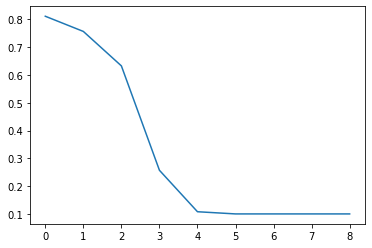

In [ ]:
plt.plot(acc_list)

In [ ]:
acc_list = list()
for lr in tqdm(np.arange(0.01, 0.2, 0.01)):
  tmp_acc_list = list()
  for _ in range(10):
    mlp = keras.models.Sequential()
    mlp.add(Flatten(input_shape=(28, 28)))
    for _ in range(2):
      mlp.add(Dense(64, activation='sigmoid'))
    mlp.add(Dense(10, activation='softmax'))
    optimizer = keras.optimizers.SGD(learning_rate=lr)
    mlp.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    mlp.fit(x_train, y_train, epochs=10, batch_size=32, validation_split=0.25, verbose=0)
    acc = mlp.evaluate(x_test, y_test, verbose=0)[1]
    tmp_acc_list.append(acc)
  acc = sum(tmp_acc_list) / len(tmp_acc_list)
  acc_list.append(acc)

  0%|          | 0/19 [00:00<?, ?it/s]

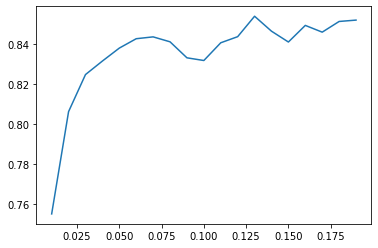

In [ ]:
plt.plot(np.arange(0.01, 0.2, 0.01), acc_list)

In [ ]:
acc_list = list()
for m in tqdm(np.arange(0.00, 0.2, 0.01)):
  tmp_acc_list = list()
  for _ in range(10):
    mlp = keras.models.Sequential()
    mlp.add(Flatten(input_shape=(28, 28)))
    for _ in range(2):
      mlp.add(Dense(64, activation='sigmoid'))
    mlp.add(Dense(10, activation='softmax'))
    optimizer = keras.optimizers.SGD(momentum=m)
    mlp.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    mlp.fit(x_train, y_train, epochs=10, batch_size=32, validation_split=0.25, verbose=0)
    acc = mlp.evaluate(x_test, y_test, verbose=0)[1]
    tmp_acc_list.append(acc)
  acc = sum(tmp_acc_list) / len(tmp_acc_list)
  acc_list.append(acc)

  0%|          | 0/20 [00:00<?, ?it/s]

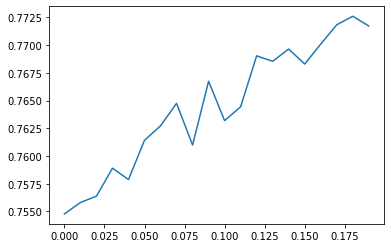

In [ ]:
plt.plot(np.arange(0.00, 0.2, 0.01), acc_list)